In [1]:
import os

import pandas as pd
import preprocess
import torch
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from augmentations import balance_classes_with_augmentation

In [2]:
dataset1 = pd.DataFrame(load_dataset('financial_phrasebank', 'sentences_allagree')['train'])
dataset2 = pd.DataFrame(load_dataset('financial_phrasebank', 'sentences_75agree')['train'])
dataset3 = pd.DataFrame(load_dataset('financial_phrasebank', 'sentences_66agree')['train'])

In [3]:
train = pd.concat([dataset1, dataset2, dataset3])
train.groupby('label').describe()

sentence                                                               
         count unique                                                top freq
label                                                                        
0         1237    514  Jan. 6 -- Ford is struggling in the face of sl...    3
1         6072   2529  Ahlstrom 's share is quoted on the NASDAQ OMX ...    6
2         2625   1168  For the last quarter of 2010 , Componenta 's n...    3

In [4]:
train['sentence'] = train['sentence'].astype(str)
train['sentence'] = train['sentence'].apply(preprocess.preprocess_df)
train['sentence'] = train['sentence'].astype(str)
train = train[['sentence', 'label']]
train.to_csv('combinedData.csv')

In [5]:
train = pd.read_csv('combinedData.csv')
train['sentence'] = train['sentence'].astype(str)

In [6]:
train = train[['label', 'sentence']]
train.groupby('label').describe()

sentence                                                               
         count unique                                                top freq
label                                                                        
0         1237    504                operating profit fell eur mn eur mn    9
1         6072   2500                                 value order eur mn   21
2         2625   1142  operating profit rose eur mn eur mn correspond...   18

TRAINING


In [7]:
sentences = train['sentence'].values
labels = train['label'].values

train_sentences, eval_sentences, train_labels, eval_labels = train_test_split(
    sentences, labels, test_size=0.2, stratify=labels, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)  

batch_size = 16
epochs = 3 
learning_rate = 2e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-08)
loss_fn = torch.nn.CrossEntropyLoss()

eval_encodings = tokenizer(list(eval_sentences), truncation=True, padding=True, max_length=256, return_tensors='pt')
eval_dataset = TensorDataset(eval_encodings['input_ids'], eval_encodings['attention_mask'], torch.tensor(eval_labels))
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

k_folds = 3
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses = []
train_acc = []
val_losses = []
val_acc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_sentences, train_labels)):
    print(f"Fold {fold + 1}/{k_folds}")
    train_sentences_fold, val_sentences_fold = train_sentences[train_idx], train_sentences[val_idx]
    train_labels_fold, val_labels_fold = train_labels[train_idx], train_labels[val_idx]
    train_encodings = tokenizer(list(train_sentences_fold), truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(list(val_sentences_fold), truncation=True, padding=True, max_length=128, return_tensors='pt')

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels_fold))
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels_fold))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=target)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        _, predicted_train = torch.max(outputs.logits, 1)
        correct_train += (predicted_train == target).sum().item()
        total_train += target.size(0) 

        if total_train != 0:
            average_train_loss = total_loss / len(train_loader)
            train_losses.append(average_train_loss)
            train_accuracy = correct_train / total_train
            train_acc.append(train_accuracy)
            print(f"Fold {fold + 1}/{k_folds}, Epoch {epoch + 1}/{epochs} - Training loss: {average_train_loss:.4f} - Training accuracy: {train_accuracy:.4f}")
        else:
            print(f"Fold {fold + 1}/{k_folds}, Epoch {epoch + 1}/{epochs} - No training samples.")

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0

    val_targets = []
    val_predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=target)
            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            _, predicted_val = torch.max(logits, 1)
            correct_val += (predicted_val == target).sum().item()
            total_val += target.size(0)

            val_targets.extend(target.cpu().detach().numpy())
            val_predictions.extend(predicted_val.cpu().detach().numpy())

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = correct_val / total_val
    val_acc.append(val_accuracy)
    print(f"Fold {fold + 1}/{k_folds} - Validation loss: {average_val_loss:.4f} - Validation accuracy: {val_accuracy:.4f}")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/.virtualenvs/DM/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 1/3
Fold 1/3, Epoch 1/3 - Training loss: 0.4742 - Training accuracy: 1.0000
Fold 1/3, Epoch 2/3 - Training loss: 0.1848 - Training accuracy: 1.0000
Fold 1/3, Epoch 3/3 - Training loss: 0.1080 - Training accuracy: 1.0000
Fold 1/3 - Validation loss: 0.2542 - Validation accuracy: 0.9256
Fold 2/3
Fold 2/3, Epoch 1/3 - Training loss: 0.1489 - Training accuracy: 1.0000
Fold 2/3, Epoch 2/3 - Training loss: 0.0770 - Training accuracy: 1.0000
Fold 2/3, Epoch 3/3 - Training loss: 0.0431 - Training accuracy: 1.0000
Fold 2/3 - Validation loss: 0.0491 - Validation accuracy: 0.9860
Fold 3/3
Fold 3/3, Epoch 1/3 - Training loss: 0.0551 - Training accuracy: 1.0000
Fold 3/3, Epoch 2/3 - Training loss: 0.0338 - Training accuracy: 1.0000
Fold 3/3, Epoch 3/3 - Training loss: 0.0270 - Training accuracy: 1.0000
Fold 3/3 - Validation loss: 0.0226 - Validation accuracy: 0.9940


In [8]:
## Generating F1 scores for the holdout set
model.eval()
eval_predictions = []
eval_targets = []
correct_eval = 0
total_eval = 0

with torch.no_grad():
    for batch in eval_loader:
        input_ids, attention_mask, target = batch
        input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, predicted_eval = torch.max(logits, 1)
        
        eval_predictions.extend(predicted_eval.cpu().detach().numpy())
        eval_targets.extend(target.cpu().detach().numpy())
        
        correct_eval += (predicted_eval == target).sum().item()
        total_eval += target.size(0)
        
eval_accuracy = correct_eval / total_eval
print(f"Holdout Accuracy after training: {eval_accuracy}")
# Calculate F1 score for the evaluation set
eval_f1 = f1_score(eval_targets, eval_predictions, average='weighted')

class_names = [str(label) for label in [0,1,2]]
eval_report = classification_report(eval_targets, eval_predictions, target_names=class_names)
print("Classification Report for Holdout Set:")
print(eval_report)

Holdout Accuracy after training: 0.9602415702063413
Classification Report for Holdout Set:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       247
           1       0.97      0.98      0.97      1215
           2       0.95      0.93      0.94       525

    accuracy                           0.96      1987
   macro avg       0.95      0.95      0.95      1987
weighted avg       0.96      0.96      0.96      1987


In [12]:
eval_f1 = f1_score(eval_targets, eval_predictions, average='weighted')

print(f"Evaluation F1 score after training: {eval_f1:.4f}")

Evaluation F1 score after training: 0.9602


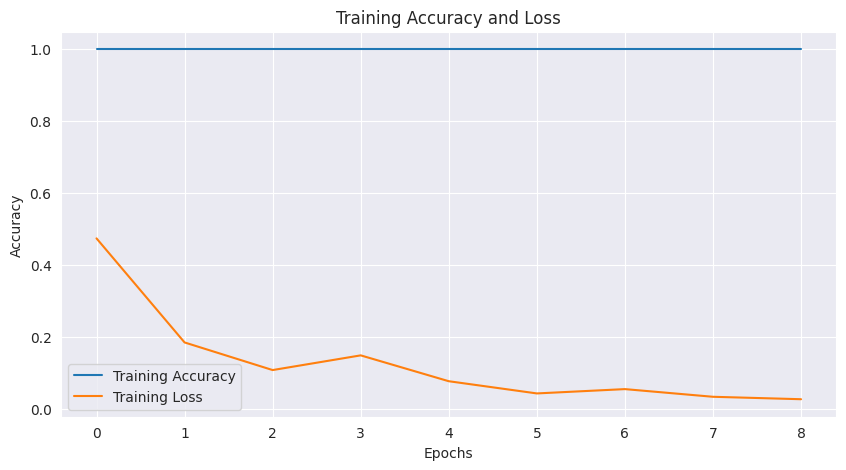

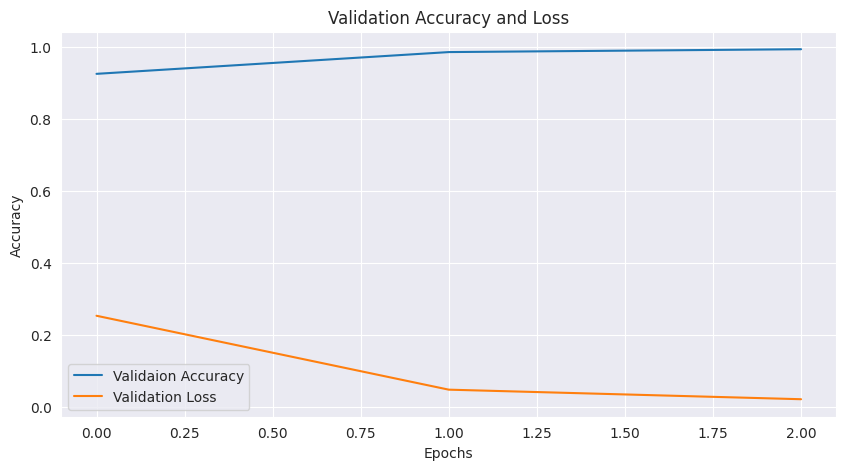

In [9]:
import matplotlib.pyplot as plt

# Plotting training accuracies and losses
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

# Plotting training accuracies and losses
plt.figure(figsize=(10, 5))
plt.plot(val_acc, label='Validaion Accuracy')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy and Loss')
plt.legend()
plt.show()



Saving the model

In [10]:
model.save_pretrained(os.getcwd()+'/distilbert/')

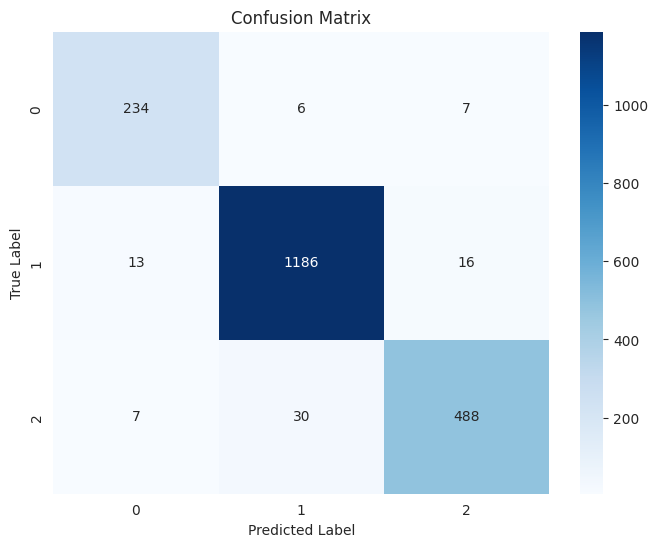

In [11]:
## Confusion matrix for the eval set
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(eval_targets, eval_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()